# Various Families

In [1]:
!pip install yellowbrick --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [3]:
df = pd.read_csv('titanic.csv')
df.sample(n=5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1303,3,0,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C,NaN,NaN,NaN
364,2,0,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S,NaN,18.0,"St Ives, Cornwall / Calumet, MI"
1295,3,0,"Windelov, Mr. Einar",male,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,S,NaN,NaN,NaN
401,2,1,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C,12,NaN,"Barcelona, Spain / Havana, Cuba"
1029,3,0,"Moran, Mr. Daniel J",male,NaN,1,0,371110,24.1500,NaN,Q,NaN,NaN,NaN


In [4]:
from sklearn import (
    metrics,
    model_selection,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

# diferentiate features matrix (X) and label target (y)
df = df.drop(columns=['name', 'ticket', 'home.dest', 'boat', 'body', 'cabin'])
X, y = df.drop(columns=['survived']), df['survived']

def tweaking(df, norm=True, hot=True, model=DummyClassifier(), cross=True):
  
  # spliting samples on train and test samples
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
      X,
      y,
      test_size=.3,
      random_state= 42
  )
  # separate numerical and categorical features
  numerical = selector(dtype_include=np.number)(X)
  categorical = selector(dtype_include=object)(X)

  # Preprocessing features

  # numerical features: imputing and scaling
  imputer = impute.IterativeImputer()
  scaler = StandardScaler()

  if norm:
    num_preprocessor = Pipeline([
        ('imputer', imputer),
        ('scaler', scaler)
    ])
  else:
    num_preprocessor = Pipeline([
        ('imputer', imputer),
    ])

  # categorical features
  one_hot_preprocessor = OneHotEncoder(handle_unknown='ignore', sparse=False)
  ordinal_preprocessor = OrdinalEncoder(
      handle_unknown='use_encoded_value', 
      unknown_value=-1
  )

  if cross:
  
    if hot:
      preprocessor = ColumnTransformer([
          ('num', num_preprocessor, numerical),
          ('cat_onehot', one_hot_preprocessor, categorical)
      ])
    
    else:
      preprocessor = ColumnTransformer([
        ('num', num_preprocessor, numerical),
        ('cat_ordinal', ordinal_preprocessor, categorical)
    ])
    
    estimator = make_pipeline(preprocessor, model)
    return estimator
  
  else:
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)

    num_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']

    X_train.loc[:, num_cols] = imputer.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = imputer.transform(X_test[num_cols])

    if norm:
      X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
      X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])

    return X_train, y_train, X_test, y_test


In [5]:
X_train, y_train, X_test, y_test = tweaking(df, cross=False)

bm = DummyClassifier()
bm.fit(X_train, y_train)
y_pred = bm.predict(X_test)
acc = bm.score(X_test, y_test)

In [6]:
acc.round(3)

0.57

In [7]:
metrics.precision_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [8]:
metrics.recall_score(y_test, y_pred)

0.0

# Various Family

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
)
import xgboost

models = [
    DummyClassifier,
    LogisticRegression, 
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    xgboost.XGBClassifier,
]

names = []
results = []
for cls in models:
  estimator = tweaking(df, model=cls(), cross=True)

  for idx, itm in enumerate(estimator.get_params().keys()):
    if idx == 4:
      names.append(itm)

  kfold = model_selection.KFold(
      n_splits=10,
      shuffle=True,
      random_state=42,
  )

  cv_results = model_selection.cross_validate(
      estimator,
      X,
      y,
      cv=kfold,
      scoring='roc_auc',
      n_jobs=-1,
  )
  results.append((cv_results['test_score'].mean(), cv_results['test_score'].std()))
# cv_results = pd.DataFrame(cv_results)
for n, res in zip(names, results):
  print(f"{n:22} AUC: "
          f"{res[0].mean():.3f} STD: {res[1].std():.2f}"
      )


dummyclassifier        AUC: 0.500 STD: 0.00
logisticregression     AUC: 0.843 STD: 0.00
decisiontreeclassifier AUC: 0.760 STD: 0.00
kneighborsclassifier   AUC: 0.837 STD: 0.00
gaussiannb             AUC: 0.821 STD: 0.00
randomforestclassifier AUC: 0.848 STD: 0.00
histgradientboostingclassifier AUC: 0.860 STD: 0.00
xgbclassifier          AUC: 0.864 STD: 0.00


# Stacking

In [10]:
!pip install mlxtend --upgrade --quiet

In [11]:
from mlxtend.classifier import StackingClassifier

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

clfs = [model() for model in models]

stack = StackingClassifier(
    classifiers = clfs,
    meta_classifier=LogisticRegression(),
)

kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
score = model_selection.cross_validate(
    stack,
    X,
    y,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1
)

print(f'{stack.__class__.__name__}  '
      f"AUC: {score['test_score'].mean(): .3f} STD: {score['test_score'].std():.2f}"
)


StackingClassifier  AUC:  0.789 STD: 0.03


# Create Model

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluate Model

In [18]:
y_pred = rf.predict(X_test)

In [17]:
rf.score(X_test, y_test)

0.7837150127226463

In [19]:
metrics.recall_score(y_test, y_pred)

0.6745562130177515

In [20]:
metrics.precision_score(y_test, y_pred)

0.7916666666666666

In [21]:
# Features importance

for col, val in sorted(
    zip(X_train.columns, rf.feature_importances_), 
    key=lambda x: x[-1],
    reverse=True
)[:]:
  print(f'{col:10}{val:10.3f}')

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050
parch          0.039
embarked_S     0.024
embarked_Q     0.009


# Optimize Model

In [24]:
rf2 = RandomForestClassifier()
params = {
    'max_features': [0.4, 'auto'],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [1, 3, 15],
    'min_samples_leaf': [.1, 1, 3],
    'random_state': [1, 10, 42],
}

cv = model_selection.GridSearchCV(
    rf2,
    params,
    n_jobs=-1,
).fit(X_train, y_train)

print(cv.best_params_)


{'criterion': 'gini', 'max_features': 0.4, 'min_samples_leaf': 3, 'n_estimators': 15, 'random_state': 1}


In [25]:
rf3 = RandomForestClassifier(**cv.best_params_)
rf3.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'Acc: {rf3.score(X_test, y_test)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')

Acc: 0.8015267175572519
Recall: 0.6745562130177515


# Confusion Matrix

In [26]:
metrics.confusion_matrix(y_test, y_pred)

array([[194,  30],
       [ 55, 114]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


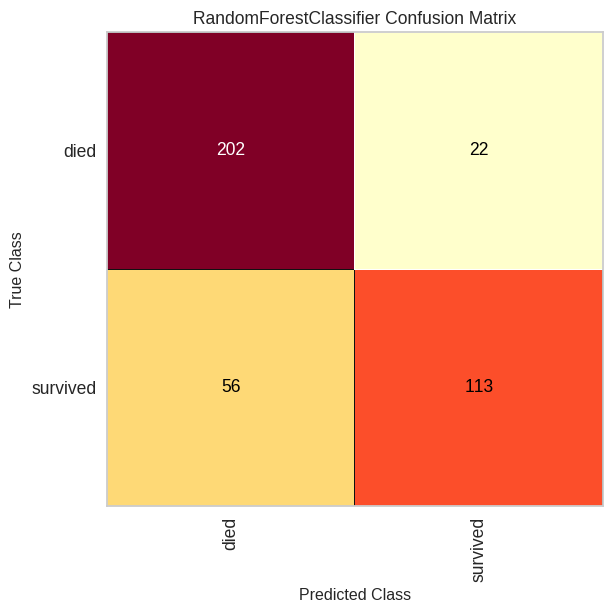

In [37]:
from yellowbrick.classifier import ConfusionMatrix

fig, ax = plt.subplots(figsize=(6, 6), dpi=105)
cm_viz = ConfusionMatrix(
    rf3,
    classes=['died', 'survived'],
    label_encoder={0:'died', 1:'survived'}
)
cm_viz.fit(X_test, y_test)
cm_viz.score(X_test, y_test)
cm_viz.poof()

fig.savefig('rf_best_cm.png', dpi=105, bbox_inches='tight');

# ROC Curve

In [30]:
metrics.roc_auc_score(y_test, y_pred)

0.77031382079459

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


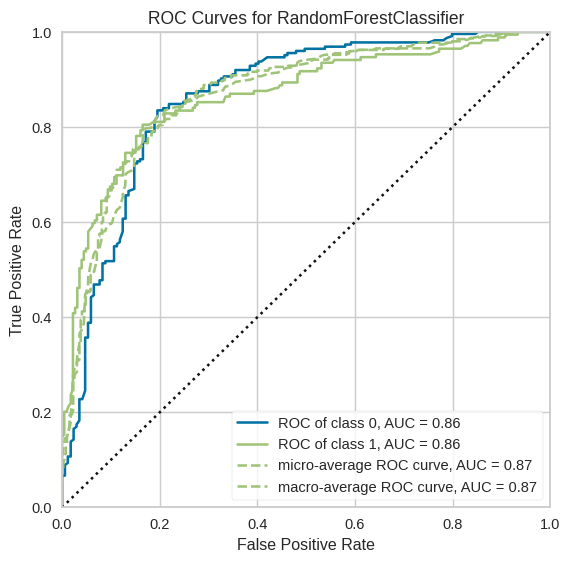

In [38]:
from yellowbrick.classifier import ROCAUC

fig, ax = plt.subplots(figsize=(6, 6), dpi=105)
roc_viz = ROCAUC(rf3)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()
fig.savefig('rf_best_roc.png', dpi=105, bbox_inches='tight');